In [52]:
import bisect
import math
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.decomposition import PCA

<br>

# Parametric vs Non-parametric
---

One way to approach learning is by trying to fit a model with parameters to the data that we observe, this is called the parametric approach to learning. Non-parametric approaches do not try to fit parameters but instead try to look for similarity between new inputs and training samples to take decisions. We discuss some examples below.

<br>

### Classification

We have a number of samples as inputs with their respective classification $\{x, c\}_n$ and would like to classify new points.

A parametric approach would consists in creating a model with parameters (for instance a linear classifier or a neural network) and optimize its parameters value through Maximum Likelihood (ML), Maximum A Posteriori (MAP) or Bayesian approaches. Once the parameters are learned, we can run the model on new data to classify it.

An example of non parametric approach to classifying a new point $x$ by looking at the K-closest examples $\{x, c\}_k$ and take the class that appears the most. This approach requires to select a metric as well as keeping in memory all the training samples.

**Non-parametric approaches do not forbid to have a training phase**. For instance, another non-parametric approach would be to run a K-mean algorithm to identify the main clusters of data, class by class, and compress this information to centroids. The K-closest approach above could be based on proximity with centroids instead.

<br>

### Density estimation

We have a number of samples $\{x\}_n$ that represents for instance the time of arrival of bus in a bus station. We would like to build a model that approximate this generating process for another inference task.

A parametric approach would consists in creating a model (for instance, an exponential distribution with unknown parameter $\lambda$) and fit this model using again the familiar ML, MAP or Bayesian approaches. Once the distribution $p(x)$ is known, we can use it to generate new samples.

A non parametric approach could for instance rely on the law of large numbers. Inside a small volume of size $V$, count the number of elements $N_V$. The probability of generating a sample inside this volume is approximated to be equal to $p(x) = \frac{N_V}{V}$.

This approach leads to bining and is the basis for **histograms**: to generate a new sample, we select a volume based on its probability $\frac{N_V}{N}$ and then pick uniformly a point inside this volume. Another similar approach, this time to estimate the probability of a given point $x$, is to look for a small volume around a point $x$ to estimate its probability:

&emsp; $\displaystyle p(x) = \frac{1}{N h^D} \sum_n k \big( \frac{x - x_n}{h} \big)$
&emsp; where:
&emsp; $k(u) = \delta (\forall i, |u_i| \le 0.5)$
&emsp; $h$ is the width of the cube
&emsp; $D$ is the dimensionality of $x$

The main problem with these approaches is the **curse of dimensionality**: to be precise and lead to smooth density functions, this methods requires a high number of regions of size $V$ which grows exponentially with the number of dimensions.

A more advanced approach is to approximate the regions of high densities with gaussians kernel, leading to:

&emsp; $\displaystyle p(x) = \frac{1}{N} \sum_n \frac{1}{\sqrt{2 \pi h^2}} e^{\textstyle - \frac{\Vert x - x_n \Vert^2}{2 h^2} }$
&emsp; where
&emsp; $h$ controls the influence reach of each data point

<br>

### Regression

We have a number of samples with their target values $\{x, t\}_n$ and we wish to return the value $t$ associated with new data points $x$. This problem is actually pretty linked to density estimation: we could see it as learning $p(x,t)$ from which we can deduce $p(t|x)$.

A parametric approach would consists in building a model (linear model, artificial neural network) with parameters $\theta$ and to maximize (for instance) the maximum likelihood of the model $\prod p(t_n|x_n,\theta)$ with respect to $\theta$ to find the parameters $\theta$.

A non parametric approach could consists in comparing the new data point $x$ to the sample points $x_n$, and use these similarity measure to assign it a linear combination of the values $t_n$:

&emsp; $\displaystyle y = \sum_n k(x, x_n) t_n$
&emsp; which is true only if $\forall i, j, \; k(x_i, x_j) = \delta_{ij}$ (orthogonality)
&emsp; $\iff$
&emsp; $K = X X^T = I_n$

Why? Because **the $\{t\}_n$ must be decomposed on the basis** $\{x\}_n$, as there are highly correlated to each other for two points that are similar. Decomposing a vector $x$ on the basis $U = (u_1, \dots u_n)$ is equivalent to finding the vector $y$ expressed in the basis $U$ such that $x = U y$, and so $y = U^{-1} x$. In our case, the basis to decompose our $\{t\}_n$ on is $K = X X^T$:

&emsp; $t'_n = K^{-1} t_n$
&emsp; $\implies$
&emsp; $\displaystyle t = \sum_n k(x, x_n) K^{-1} t_n$
&emsp; $\implies$
&emsp; $\boxed{y = k(x)^T K^{-1} t}$
&emsp; where $k(x) = \big(k(x,x_1), \dots k(x, x_n) \big)$

This method is the basis of what we call **kernel methods** and **gaussian processes** which we will explore in future sections.

<br>

# Examples
---

* classification of points
* arrival of passengers
* regression on simple curve

<br>

### Non-parameter point classification

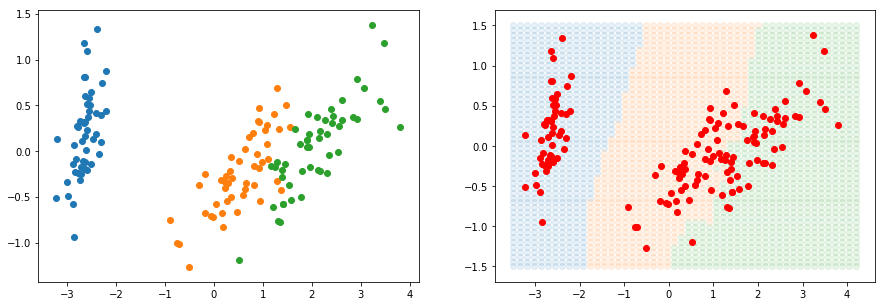

In [19]:
class ClosestPoint:
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    
    def predict(self, X):
        out = []
        for x in X:
            d = np.array([np.dot(x - x_i, x - x_i) for x_i in self.X])
            i = np.argmin(d)
            out.append(self.Y[i])
        return np.array(out)
                

iris = load_iris()
X = iris['data']
Y = iris['target']
pca = PCA(n_components=2)
X = pca.fit_transform(X)

model = ClosestPoint(X, Y)
test_X = np.stack(np.meshgrid(np.linspace(-3.5, 4.2, 50),
                              np.linspace(-1.5, 1.5, 50))).transpose((1, 2, 0)).reshape((-1, 2))
test_Y = model.predict(test_X)

_, ax = plt.subplots(figsize=(15,5), ncols=2)
for class_id in 0,1,2:
    X_class = X[Y == class_id]
    ax[0].scatter(X_class[:,0], X_class[:,1])
for class_id in 0,1,2:
    X_class = test_X[test_Y == class_id]
    ax[1].scatter(X_class[:,0], X_class[:,1], alpha=0.1)
ax[1].scatter(X[:,0], X[:,1], color='red')
plt.show()

<br>

### Density estimation

Let us approximate an exponetial distribution with $\lambda = 0.5$, first with histogram and then with KDE.

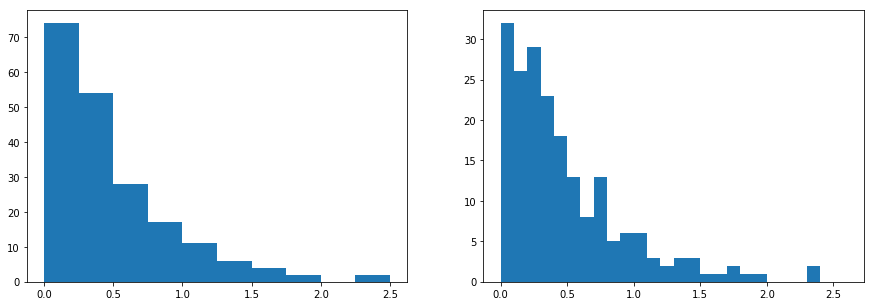

In [48]:
X = np.sort(np.random.exponential(scale=0.5, size=200))

_, ax = plt.subplots(figsize=(15,5), ncols=2)
for i, dx in enumerate((0.25, 0.1)):
    ax[i].hist(X, bins=np.arange(0., np.max(X), dx))
plt.show()

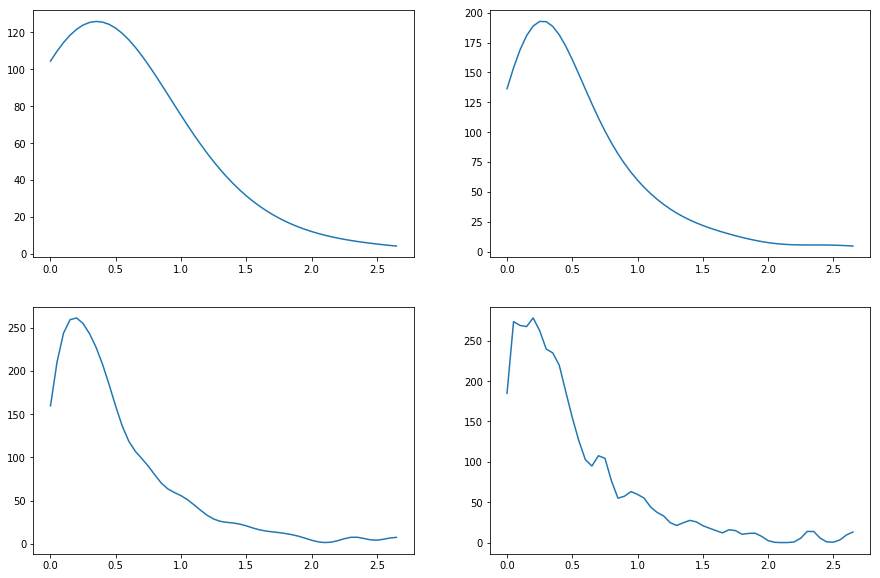

In [62]:
class KDE:
    def __init__(self, X, h: float):
        self.X = X
        self.h = h
    
    def prob_of(self, xs):
        ys = []
        for x in xs:
            kx = np.array([math.exp(- (x - x_i) ** 2 / (2 * self.h ** 2)) / math.sqrt(2 * math.pi * self.h**2) for x_i in self.X])
            ys.append(np.sum(kx))
        return np.array(ys)

test_X = np.arange(0., np.max(X), 0.05)
_, ax = plt.subplots(figsize=(15,10), ncols=2, nrows=2)
for i, dx in enumerate((0.5, 0.25, 0.1, 0.05)):
    model = KDE(X, dx)
    test_Y = model.prob_of(test_X)
    ax[i//2][i%2].plot(test_X, test_Y)
plt.show()

<br>

### Regression with kernel methods

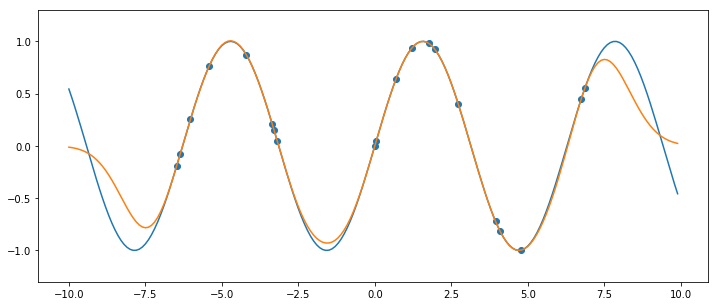

In [101]:
test_X = np.arange(-10., 10., 0.1)
test_Y = np.sin(test_X)

train_X = np.random.uniform(-7., 7., size=20)
train_Y = np.sin(train_X)

class Kernel:
    def __init__(self, X, T, h: float):
        self.X = X
        self.h = h
        K = np.array([[self.kernel(x_i, x_j) for x_j in X] for x_i in X])
        K_inv = np.linalg.inv(K)
        self.T = K_inv @ train_Y

    
    def predict(self, xs):
        ts = []
        for x in xs:
            kx = np.array([self.kernel(x, x_i) for x_i in self.X])
            ts.append(np.dot(kx, self.T))
        return ts
    
    def kernel(self, x, y):
        return math.exp(- (x - y) ** 2 / (2 * self.h ** 2)) / math.sqrt(2 * math.pi * self.h**2)

model = Kernel(train_X, train_Y, h=1.0)
    
plt.figure(figsize=(12, 5))
plt.plot(test_X, test_Y)
plt.plot(test_X, model.predict(test_X))
plt.scatter(train_X, train_Y)
plt.ylim(-1.3, 1.3)
plt.show()